In [182]:
import numpy.matlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import timeit

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.animation as animation
tfd = tfp.distributions
tfdtype = tf.float32

In [183]:
class SVN:
    def __init__(self, model, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = 100
        self.nIterations = 100
        self.stepsize = 1
        # self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis]
        if len(arg) == 0:
            self.resetParticles()
        else:
            self.particles = arg[0]
        
    def apply(self,debug = False):
        maxmaxshiftold = np.inf
        maxshift = np.zeros(self.nParticles)
        Q = np.zeros( (self.DoF, self.nParticles) )
        for iter_ in range(self.nIterations):
            F = self.model.getForwardModel(self.particles)
            J = self.model.getJacobianForwardModel(self.particles)
            gmlpt  = self.model.getGradientMinusLogPosterior(self.particles, F, J)
            Hmlpt  = self.model.getGNHessianMinusLogPosterior(self.particles, J)
            M = np.mean(Hmlpt, 2)
            
            for i_ in range(self.nParticles):
                sign_diff = self.particles[:,i_,np.newaxis] - self.particles
                Msd   = np.matmul(M, sign_diff)
                kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
                gkern = Msd * kern
                
                mgJ = np.mean(- gmlpt * kern + gkern , 1)
                HJ  = np.mean(Hmlpt * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles
                Q[:,i_] = np.linalg.solve(HJ, mgJ)
                if debug == True:
                  print('HJ:',HJ)
                maxshift[i_] = np.linalg.norm(Q[:,i_], np.inf)

            if debug == True:
              print('Q:',Q)
              print('increment:',self.stepsize * Q)  
            self.particles += self.stepsize * Q
            maxmaxshift = np.max(maxshift)
            
            if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
                print('Reset particles...')
                self.resetParticles()
                self.stepsize = 1
            elif maxmaxshift < maxmaxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxmaxshiftold = maxmaxshift
                          
    def resetParticles(self):
        self.particles = np.random.normal( scale = 1, size = (self.DoF, self.nParticles) )


In [184]:
class GAUSSIAN():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A    = np.random.normal( size = (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.sum(self.A * thetas, 0)
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.matlib.repmat(self.A, 1, nSamples)
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [185]:
model = GAUSSIAN()
svn = SVN(model)

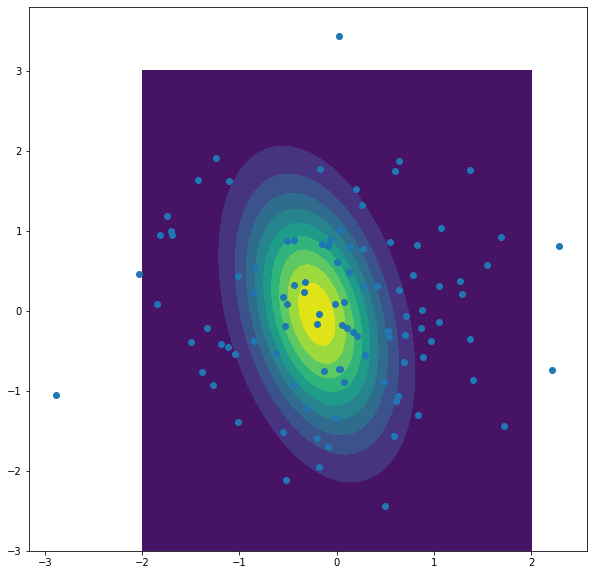

In [186]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [212]:
class TFGaussian():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = tf.eye((self.DoF),dtype = tf.float64)
        self.cov = self.std0 ** 2

        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A    = np.random.normal( size = (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
    
    def getForwardModel(self,thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = self.A[0]*thetas[0,:]+self.A[1]*thetas[1,:]
        return tmp
    
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
    
    def getMinusLogPosterior(self, thetas):
        D_n = self.data
        mu0 = tf.squeeze(self.mu0)

        mvn = tfd.MultivariateNormalTriL(
            loc=mu0,
            scale_tril=tf.linalg.cholesky(self.cov))

        # define likelihood
        # y = A1*x1-A2*x2
        y = tfd.Normal(loc=tf.matmul(tf.transpose(self.A),tf.transpose(thetas)),scale=self.stdn)
        # return the posterior probability
        return -(mvn.log_prob(thetas)
               + tf.reduce_sum(y.log_prob(D_n), axis=0))
    
    def getGradientMinusLogPrior(self, thetas):
        with tf.GradientTape() as t:
            t.watch(thetas)
            logpost = self.getMinusLogPosterior(thetas)
        grad = t.gradient(logpost,thetas)
        return grad
    
    def getGNHessianMinusLogPosterior(self, thetas):
        Hess = tf.TensorArray(tfdtype, size=int(2))
        i = 0
        for i in range(2):
            tangents = np.zeros(thetas.shape)
            tangents[:,i]=1
            tangents = tf.convert_to_tensor(tangents,dtype=tf.float64)
            with tf.autodiff.ForwardAccumulator(thetas, tangents) as acc:
                with tf.GradientTape(watch_accessed_variables=False) as t:
                    t.watch(thetas)
                    logpost = tfmodel.getMinusLogPosterior(thetas)
                loss = t.gradient(logpost,thetas)
                tf.print(loss)
            hess = acc.jvp(loss)
            Hess = Hess.write(i, hess)

        Hess = Hess.stack()
        return Hess

In [223]:
thetas = tf.constant([[0.,0.]],tf.float64)
thetas = tf.transpose(tf.convert_to_tensor(svn.particles,tf.float64))
with tf.GradientTape() as t:
    t.watch(thetas)
    logpost = tfmodel.getMinusLogPosterior(thetas)
grad = t.gradient(logpost,thetas)
grad

<tf.Tensor: shape=(100, 2), dtype=float64, numpy=
array([[ 1.34529215e+01,  3.12402114e+00],
       [ 2.80582305e+00, -4.10262458e-01],
       [ 4.63950513e+00,  7.51214579e-01],
       [ 6.33975006e+00,  9.60822604e-01],
       [ 1.19898447e+00,  6.38076830e-02],
       [ 3.51245548e+00,  1.99731865e+00],
       [ 2.73658289e+00, -1.12254144e+00],
       [ 5.09437638e+00,  2.95242628e-01],
       [-3.74556103e+00, -1.30484423e-01],
       [-2.51885154e-01, -7.77447339e-01],
       [-1.95095220e+00, -1.23817626e+00],
       [ 1.51327883e+00, -2.22531935e+00],
       [-1.29622699e+00, -1.81589012e+00],
       [-6.22301225e+00, -1.95529872e+00],
       [ 2.09738965e+00, -1.78649570e-01],
       [ 1.44601197e+00,  6.50441427e-02],
       [ 6.08500834e-01, -6.13742511e-01],
       [ 7.87896080e+00,  1.74230459e+00],
       [ 7.41475621e+00,  2.34787272e+00],
       [ 3.45125758e+00,  9.34198118e-01],
       [ 9.46962815e+00,  2.21719460e+00],
       [-1.55482852e+00, -1.47674737e+00],
    

In [236]:
Hess = tf.TensorArray(tf.float64, size=int(2))
i = 0
for i in range(2):
    tangents = np.zeros(thetas.shape)
    tangents[:,i]=1
    tangents = tf.convert_to_tensor(tangents,dtype=tf.float64)
    with tf.autodiff.ForwardAccumulator(thetas, tangents) as acc:
        with tf.GradientTape(watch_accessed_variables=False) as t:
            t.watch(thetas)
            logpost = tfmodel.getMinusLogPosterior(thetas)
        loss = t.gradient(logpost,thetas)
        tf.print(loss)
    hess = acc.jvp(loss)
    Hess = Hess.write(i, hess)

Hess = Hess.stack()

[[13.452921476689326 3.1240211375559213]
 [2.8058230517074705 -0.41026245760254271]
 [4.639505134588255 0.75121457917257639]
 ...
 [-6.79877017217221 0.13998425525695213]
 [2.1264730984268292 0.8967219418999155]
 [0.99276434854348361 1.0734941797945543]]
[[13.452921476689326 3.1240211375559213]
 [2.8058230517074705 -0.41026245760254271]
 [4.639505134588255 0.75121457917257639]
 ...
 [-6.79877017217221 0.13998425525695213]
 [2.1264730984268292 0.8967219418999155]
 [0.99276434854348361 1.0734941797945543]]


In [237]:
Hess

<tf.Tensor: shape=(2, 100, 2), dtype=float64, numpy=
array([[[5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.85148765],
        [5.10126894, 0.851487

In [238]:
model.getGNHessianMinusLogPosterior(svn.particles)

array([[[5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5.10126894, 5.10126894, 5.10126894,
         5.10126894, 5.10126894, 5

In [214]:
tfmodel.getGradientMinusLogPrior(tf.transpose(svn.particles))

<tf.Tensor: shape=(100, 2), dtype=float64, numpy=
array([[ 1.34529215e+01,  3.12402114e+00],
       [ 2.80582305e+00, -4.10262458e-01],
       [ 4.63950513e+00,  7.51214579e-01],
       [ 6.33975006e+00,  9.60822604e-01],
       [ 1.19898447e+00,  6.38076830e-02],
       [ 3.51245548e+00,  1.99731865e+00],
       [ 2.73658289e+00, -1.12254144e+00],
       [ 5.09437638e+00,  2.95242628e-01],
       [-3.74556103e+00, -1.30484423e-01],
       [-2.51885154e-01, -7.77447339e-01],
       [-1.95095220e+00, -1.23817626e+00],
       [ 1.51327883e+00, -2.22531935e+00],
       [-1.29622699e+00, -1.81589012e+00],
       [-6.22301225e+00, -1.95529872e+00],
       [ 2.09738965e+00, -1.78649570e-01],
       [ 1.44601197e+00,  6.50441427e-02],
       [ 6.08500834e-01, -6.13742511e-01],
       [ 7.87896080e+00,  1.74230459e+00],
       [ 7.41475621e+00,  2.34787272e+00],
       [ 3.45125758e+00,  9.34198118e-01],
       [ 9.46962815e+00,  2.21719460e+00],
       [-1.55482852e+00, -1.47674737e+00],
    

In [213]:
tfmodel = TFGaussian()


In [130]:
m = tf.constant([[0.,0.],[1.,1.],[3.,4.]],tf.float64)
tfmodel.getMinusLogPosterior(m)
with tf.GradientTape() as t:
    t.watch(m)
    logpost = tfmodel.getMinusLogPosterior(m)
t.gradient(logpost,m)

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[ 1.0712115 ,  0.22240028],
       [ 7.02396808,  2.25067009],
       [19.7809689 ,  7.48399189]])>

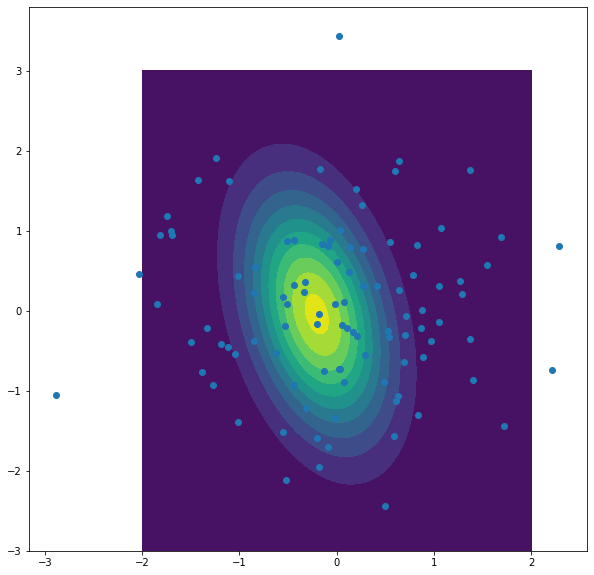

In [123]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - tfmodel.getMinusLogPosterior( tf.transpose(np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ))) .numpy()-np.log((2*np.pi)**-0.5))\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [167]:
tfmodel.A

array([[-0.6075477 ],
       [-0.12613641]])

In [168]:
model.A

array([[-0.6075477 ],
       [-0.12613641]])

In [245]:
norm = tfd.Normal(loc = 0., scale = 1)

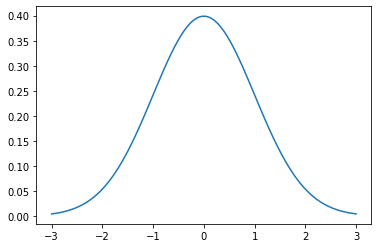

In [246]:
x = np.linspace(-3,3,100)
plt.plot(x,norm.prob(x))

In [247]:
norm.prob(x)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.00443185, 0.00530579, 0.00632877, 0.00752133, 0.00890582,
       0.0105065 , 0.01234943, 0.01446242, 0.01687483, 0.01961746,
       0.02272222, 0.0262219 , 0.03014962, 0.03453856, 0.03942136,
       0.0448295 , 0.05079264, 0.05733799, 0.06448953, 0.07226708,
       0.08068571, 0.08975478, 0.09947713, 0.10984841, 0.12085625,
       0.13247967, 0.14468855, 0.1574432 , 0.17069405, 0.18438165,
       0.19843663, 0.21277994, 0.22732352, 0.24197073, 0.25661743,
       0.27115285, 0.2854612 , 0.2994227 , 0.31291556, 0.3258175 ,
       0.3380076 , 0.34936816, 0.35978657, 0.3691572 , 0.37738323,
       0.38437808, 0.39006722, 0.39438924, 0.39729717, 0.39875916,
       0.39875916, 0.39729717, 0.39438924, 0.39006722, 0.38437808,
       0.37738323, 0.3691572 , 0.35978657, 0.34936816, 0.3380076 ,
       0.3258175 , 0.31291556, 0.2994227 , 0.2854612 , 0.27115285,
       0.25661743, 0.24197073, 0.22732352, 0.21277994, 0.19843663,
       0.18438

In [248]:
x = tf.convert_to_tensor(x,tf.float32)
with tf.GradientTape() as t:
    t.watch(x)
    MinusLogProb = -norm.log_prob(x)
grad = t.gradient(MinusLogProb,x)

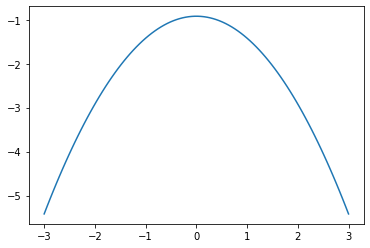

In [252]:
plt.plot(x,-MinusLogProb)

# gradient

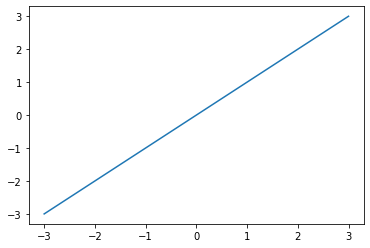

In [250]:
plt.plot(x,grad)